In [18]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from keras.callbacks import History

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

* **input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
* **output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
* **input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

# Zad.

Poberz dane z konkursu http://2017.poleval.pl/index.php/tasks/ Task 2. Sentiment analysis

Pojedyńczy plik można pobrać z tąd:
https://www.dropbox.com/sh/tjq47ybybgnrbel/AAAVbp0UkQTAbKWVMIi5mtHpa?dl=0


In [4]:
file_with_filtered_embeddings = "Dane/data_poleval/embeddings.txt"

words2ids = {}
embeddings = []

embeddings.append(np.zeros(300)) # rezerwujemy embeddingi na paddin i nieznane slowa
embeddings.append(np.zeros(300))

i = 0
with open(file_with_filtered_embeddings,"r", encoding="utf8")as f:
    for line in f:
        toks = line.split(" ")
        word = toks[0]
        embeddings.append(np.array([float(x) for x in toks[1:]]))
        words2ids[word] = i+2 # +3 - przesuniecie po to zeby specjalne embeddingi byly na pozycji 0 i 1
        i = i + 1


embeddings = np.array(embeddings)
print(embeddings.shape)

(5000, 300)


In [7]:
words2ids["Słodkawy"]

2731

In [8]:
embeddings[words2ids["Słodkawy"]]

array([ 0.0695675 , -0.0123177 ,  0.0190564 ,  0.0205853 , -0.0586069 ,
        0.123962  , -0.0113998 ,  0.0486168 , -0.0593128 ,  0.0244056 ,
        0.00806909, -0.0123139 ,  0.0318254 ,  0.0375928 ,  0.0488764 ,
       -0.0311151 , -0.0571845 ,  0.00886492, -0.023981  , -0.0729585 ,
        0.00780728, -0.0103228 ,  0.0451543 , -0.00375595, -0.01016   ,
        0.0157066 ,  0.0933215 ,  0.00742586,  0.0662036 ,  0.0147866 ,
       -0.0326982 , -0.105277  ,  0.0939024 , -0.141137  , -0.0390246 ,
        0.0307554 , -0.124878  ,  0.092467  , -0.0449775 ,  0.0278756 ,
        0.0120974 ,  0.0402319 , -0.0602183 ,  0.117348  , -0.0286395 ,
        0.0226578 , -0.0100841 ,  0.0928551 ,  0.0676152 , -0.0280563 ,
        0.0516412 ,  0.0899037 , -0.0634045 ,  0.0149937 , -0.0472655 ,
       -0.0638853 , -0.00977132, -0.0440674 ,  0.00945409, -0.0873957 ,
        0.0113474 ,  0.00536351,  0.0406797 ,  0.051127  ,  0.0194782 ,
        0.00793247,  0.00938793,  0.0813627 , -0.0323478 ,  0.00

In [5]:
from keras.preprocessing import sequence as seq
def load_and_transform_data_to_phrases(labels, parents, tokens, words2ids):

    """
    Dokumentacja
    """
    

    transform_label = {'-1':0, '0':1, '1':2}
    
    l = open(labels, "r", encoding="utf8")
    labels = [[transform_label[y] for y in x.split()] for x in l.readlines()] 
    l.close()

    p = open(parents,"r", encoding="utf8")
    parents = [[int(y) for y in x.split()] for x in p.readlines()]
    p.close()

    t = open(tokens,"r", encoding="utf8")
    tokens = [x.split() for x in t.readlines()]
    t.close()
    
    k = 0
    result = []
    
    for labels_i,parents_i,tokens_i in zip(labels,parents,tokens):
        
        k = k + 1
         
        s = []
        for i in range(len(tokens_i)):
            s.append([i,int(parents_i[i]),labels_i[i],tokens_i[i]])


        if len(s) == 1: #przypadek gdy fraza sklada sie z jednego tokena

            result.append((\
                                  tokens[0],
                                  np.array([words2ids.get(tokens[0], 1)]),\
                                  np.array(labels_i[0]) \
                              ))    
                           
        else: 
            
            for i in range(len(s)): 
                children = []
                for j in range(len(s)):
                    if s[j][1] == i+1:
                        children.append(s[j][0])
                s[i].append(children)

                
            words = [x[0] for x in s]
            children = [x[4] for x in s]
            tokens = [x[3] for x in s]
            labels_in_batch = [x[2] for x in s]
        
            phrases = [[k] for k in range(len(children))]
            for i in range(len(children)):
                for e in phrases[i]:
                    phrases[i].extend(children[e])
           
            phrases = [ np.sort(x) for x in phrases]
          
            phrases = list(zip([np.array(tokens_i)[x] for x in phrases],
                               [np.array([words2ids.get(t,1) for t in tokens_i])[x] for x in phrases],
                               labels_i))

            result.extend(phrases)
           
    return result


In [6]:
train_data = load_and_transform_data_to_phrases("Dane/data_poleval/training-treebank/rev_labels.txt", "Dane/data_poleval/training-treebank/rev_parents.txt","Dane/data_poleval/training-treebank/rev_sentence.txt",words2ids)
test_data = load_and_transform_data_to_phrases("Dane/data_poleval/poleval_test/gold_labels", "Dane/data_poleval/poleval_test/polevaltest_parents.txt","Dane/data_poleval/poleval_test/polevaltest_sentence.txt",words2ids) 

In [11]:
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences

lengths1 = [len(x[0]) for x in train_data]
lengths2 = [len(x[0]) for x in test_data]
max_len = max(lengths1 + lengths2)

x_train = np.array([x[1] for x in train_data])
x_test = np.array([x[1] for x in test_data])

y_train = np.array([x[2] for x in train_data])
y_test = np.array([x[2] for x in test_data])

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

X_train = pad_sequences(x_train, maxlen=max_len)
X_test = pad_sequences(x_test, maxlen=max_len)

In [23]:
print(y_train.shape)
X_train

(9510, 3)


array([[   0,    0,    0, ...,    0,    0, 2731],
       [   0,    0,    0, ..., 1465,  515,    1],
       [   0,    0,    0, ...,    0,    0, 1465],
       ...,
       [   0,    0,    0, ...,    0,    0, 2397],
       [   0,    0,    0, ...,    0, 2397, 2903],
       [   0,    0,    0, ...,    0,    0,    1]])

In [39]:
history_1 = History()
model = Sequential()
model.add(Embedding(5000, 300, input_length=max_len))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 300)           1500000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 36003     
Total params: 1,536,003
Trainable params: 1,536,003
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[history_1])
# model.evaluate(x_test, y_test)

Train on 7608 samples, validate on 1902 samples
Epoch 1/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.4773 - categorical_accuracy: 0.8178 - val_loss: 0.4680 - val_categorical_accuracy: 0.8102
Epoch 2/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.2761 - categorical_accuracy: 0.9004 - val_loss: 0.4363 - val_categorical_accuracy: 0.8233
Epoch 3/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.1552 - categorical_accuracy: 0.9506 - val_loss: 0.4503 - val_categorical_accuracy: 0.8386
Epoch 4/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0981 - categorical_accuracy: 0.9679 - val_loss: 0.4552 - val_categorical_accuracy: 0.8375
Epoch 5/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0645 - categorical_accuracy: 0.9802 - val_loss: 0.4736 - val_categorical_accuracy: 0.8417
Epoch 6/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0484 - categorical_accuracy:

Epoch 49/100
7608/7608 [==============================] - 10s 1ms/step - loss: 0.0096 - categorical_accuracy: 0.9962 - val_loss: 1.0942 - val_categorical_accuracy: 0.8349
Epoch 50/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0107 - categorical_accuracy: 0.9955 - val_loss: 1.1080 - val_categorical_accuracy: 0.8370
Epoch 51/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0099 - categorical_accuracy: 0.9961 - val_loss: 1.0962 - val_categorical_accuracy: 0.8344
Epoch 52/100
7608/7608 [==============================] - 10s 1ms/step - loss: 0.0094 - categorical_accuracy: 0.9962 - val_loss: 1.1164 - val_categorical_accuracy: 0.8370
Epoch 53/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0097 - categorical_accuracy: 0.9962 - val_loss: 1.1131 - val_categorical_accuracy: 0.8333
Epoch 54/100
7608/7608 [==============================] - 9s 1ms/step - loss: 0.0099 - categorical_accuracy: 0.9962 - val_loss: 1.1294 - val_categor

In [41]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.748960


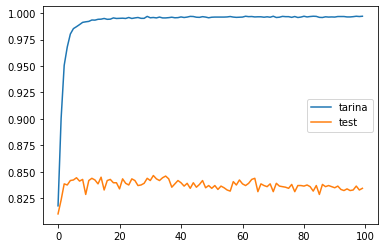

In [42]:
plt.plot(history_1.history['categorical_accuracy'], label = "tarina")
plt.plot(history_1.history['val_categorical_accuracy'], label = "test")


plt.legend()
plt.show()

# Zad
Użyj Pretrain embedding


In [43]:
history_2 = History()
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[history_2])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 300)           1500000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 36003     
Total params: 1,536,003
Trainable params: 36,003
Non-trainable params: 1,500,000
_________________________________________________________________
Train on 7608 samples, validate on 1902 samples
Epoch 1/100
7608/7608 [==============================] - 1s 124us/step - loss: 0.6515 - categorical_accuracy: 0.8162 - val_loss: 0.6899 - val_categorical_accuracy: 0.8160
Epoch 2/100
7608/7608 [==============================] - 1s 97us/step - loss: 0.4182 - categorical_accuracy: 0.8935 - val_loss: 0.6861 - val_categoric

7608/7608 [==============================] - 1s 104us/step - loss: 0.0704 - categorical_accuracy: 0.9780 - val_loss: 1.4099 - val_categorical_accuracy: 0.8438
Epoch 45/100
7608/7608 [==============================] - 1s 100us/step - loss: 0.0697 - categorical_accuracy: 0.9783 - val_loss: 1.4106 - val_categorical_accuracy: 0.8407
Epoch 46/100
7608/7608 [==============================] - 1s 106us/step - loss: 0.0729 - categorical_accuracy: 0.9777 - val_loss: 1.4355 - val_categorical_accuracy: 0.8481
Epoch 47/100
7608/7608 [==============================] - 1s 116us/step - loss: 0.0686 - categorical_accuracy: 0.9771 - val_loss: 1.4532 - val_categorical_accuracy: 0.8428
Epoch 48/100
7608/7608 [==============================] - 1s 112us/step - loss: 0.0690 - categorical_accuracy: 0.9777 - val_loss: 1.4668 - val_categorical_accuracy: 0.8460
Epoch 49/100
7608/7608 [==============================] - 1s 109us/step - loss: 0.0699 - categorical_accuracy: 0.9787 - val_loss: 1.4759 - val_categorica

Epoch 92/100
7608/7608 [==============================] - 1s 112us/step - loss: 0.0574 - categorical_accuracy: 0.9807 - val_loss: 2.0217 - val_categorical_accuracy: 0.8475
Epoch 93/100
7608/7608 [==============================] - 1s 140us/step - loss: 0.0567 - categorical_accuracy: 0.9825 - val_loss: 1.9923 - val_categorical_accuracy: 0.8444
Epoch 94/100
7608/7608 [==============================] - 1s 100us/step - loss: 0.0560 - categorical_accuracy: 0.9821 - val_loss: 2.0231 - val_categorical_accuracy: 0.8454
Epoch 95/100
7608/7608 [==============================] - 1s 104us/step - loss: 0.0581 - categorical_accuracy: 0.9819 - val_loss: 1.9883 - val_categorical_accuracy: 0.8460
Epoch 96/100
7608/7608 [==============================] - 1s 100us/step - loss: 0.0559 - categorical_accuracy: 0.9830 - val_loss: 1.9845 - val_categorical_accuracy: 0.8496
Epoch 97/100
7608/7608 [==============================] - 1s 99us/step - loss: 0.0540 - categorical_accuracy: 0.9826 - val_loss: 2.0353 - va

In [44]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.757678


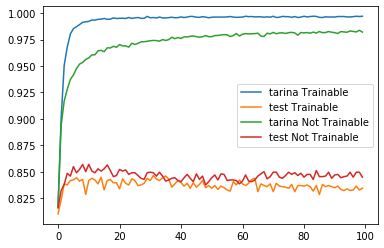

In [45]:
plt.plot(history_1.history['categorical_accuracy'], label = "tarina Trainable")
plt.plot(history_1.history['val_categorical_accuracy'], label = "test Trainable")

plt.plot(history_2.history['categorical_accuracy'], label = "tarina Not Trainable")
plt.plot(history_2.history['val_categorical_accuracy'], label = "test Not Trainable")


plt.legend()
plt.show()

# Zad
Użyj architektury
```python
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(LSTM(10))
model.add(Dense(3, activation='softmax'))
model.summary()
```

# Zad
Użyj architektury
```python
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(Conv1D(50,3))
model.add(LSTM(10))
model.add(Dense(3, activation='softmax'))
model.summary()
```

Co dokładnie robi 

```python
from keras.layers.convolutional import Conv1D
```

# Zad
Użyj architektury

```python
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(TimeDistributed(Dense(10,activation="tanh")))
model.add(LSTM(10))
model.add(Dense(3, activation='softmax'))
model.summary()
```

Co dokładnie robi 

```python
from keras.layers import TimeDistributed
```
